In [1]:
# for the model
from sequence_jacobian.examples.hank import *

# for data generation
from sequence_jacobian.utilities.shocks import simulate
from sequence_jacobian.utilities.plotting import *

# for likelihood evaluation
import sequence_jacobian.estimation as sje

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from sequence_jacobian import create_model, ShockDict, AR, DensityModel
import pymc as mc
import arviz as az

## Model

We use the Heterogeneous Agent model in the `examples` folder with two outputs
output `Y` and inflation `pi`.

In [3]:
household = hh.add_hetinputs([transfers, wages, make_grids])
household = household.add_hetoutputs([labor_supply])

blocks = [household, firm, monetary, fiscal, mkt_clearing, nkpc]
hank_model = create_model(blocks, name="One-Asset HANK")

In [4]:
calibration = {
    "r": 0.005,
    "rstar": 0.005,
    "eis": 0.5,
    "frisch": 0.5,
    "B": 5.6,
    "mu": 1.2,
    "rho_s": 0.966,
    "sigma_s": 0.5,
    "kappa": 0.1,
    "phi": 1.5,
    "Y": 1.0,
    "Z": 1.0,
    "pi": 0.,
    "nS": 2,
    "amax": 150,
    "nA": 10
}

In [5]:
unknowns_ss = {"beta": 0.986, "vphi": 0.8}
targets_ss = {"asset_mkt": 0.0, "NE": 1.0}

blocks_ss = [household, firm, monetary, fiscal, mkt_clearing, nkpc_ss]
hank_model_ss = create_model(blocks_ss, name="One-Asset HANK SS")

cali = hank_model_ss.solve_steady_state(
    calibration, unknowns_ss, targets_ss, solver="broyden_custom"
)

ss = hank_model.steady_state(cali)

In [6]:
unknowns = ["w", "Y", "pi"]
targets = ["asset_mkt", "goods_mkt", "nkpc_res"]
inputs = ["rstar", "Z"]
outputs = ["Y", "pi"]
T = 500

## Shocks

To define shocks, we construct a `ShockDict` which contains a list of exogenous
variables and the shock we choose to employ. This module has built-ins for ARMA
shocks, but custom shocks can be implemented by creating a `Shock` subclass

In [7]:
shocks = ShockDict({
    "rstar": AR(np.array([0.7]), 1.0),
    "Z": AR(np.array([0.8]), 0.5)
})

For demonstration, let's simulate 156 quarters (as is standard in Smets and Wouters)
with the above shocks. We call `generate_impulses` to calculate the AR impulse
responses, multiply the Jacobian, and call `simulate` to generate data.

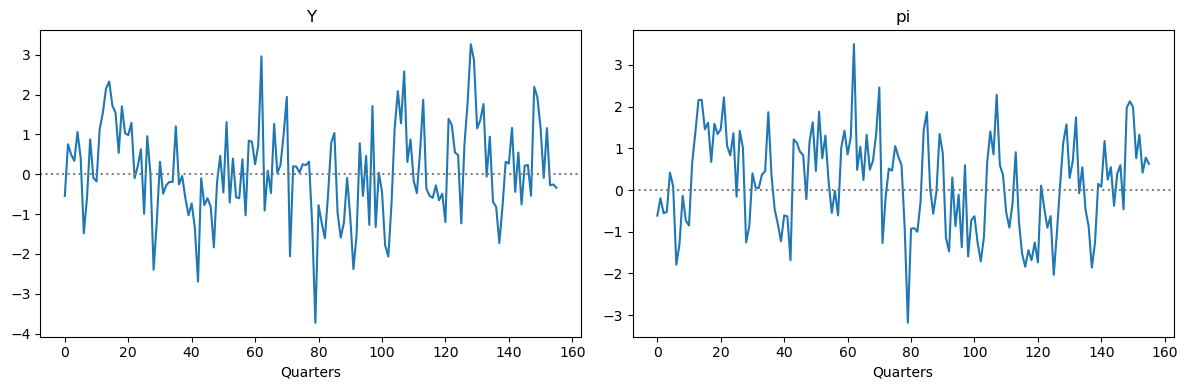

In [8]:
G = hank_model.solve_jacobian(ss, unknowns, targets, inputs, outputs, T=T)

impulses = shocks.generate_impulses(T)
irfs = {i: G @ {i: impulses[i]} for i in inputs}

data_simul = simulate(list(irfs.values()), outputs, 156)
plt = plot_timeseries(data_simul, figsize=(12, 4))

## Shock Estimation

For estimation, we construct a function `log_likelihood` which takes the model
parameters, and four standard arguments to properly run: the data, the initial 
steady state, the model, and the initial Jacobian.

For shock estimation, we only require the use of the data and the Jacobian; but
when estimating model parameters, we need just the steady state as well as the
model in order to calculate a new Jacobian.

This function get's placed within a `DensityModel` to properly evaluate the log
likelihood when making calls from within PyMC.

In [9]:
def likelihood_1(phi_rstar, sigma_rstar, phi_Z, sigma_Z, data, ss, model, jacobian):
    # construct shocks
    shocks = ShockDict({
        "rstar": AR(np.array([phi_rstar]), sigma_rstar),
        "Z": AR(np.array([phi_Z]), sigma_Z)
    })

    # construct impulse response functions
    impulses = shocks.generate_impulses(T)
    irfs = {i: jacobian @ {i: impulses[i]} for i in inputs}

    M = np.empty((T, len(outputs), len(inputs)))
    for no, o in enumerate(outputs):
        for ns, s in enumerate(inputs):
            M[:, no, ns] = irfs[s][o]

    # approximate the autocovariances
    Sigma = sje.all_covariances(M, 1)

    # compute the log posterior likelihood
    return sje.log_likelihood(data, Sigma)

The construction of the DensityModel is as follows:

In [10]:
dsge_logpdf_1 = DensityModel(
    data_simul, ss, hank_model, likelihood_1,
    unknowns, targets, inputs, T=500
)

In [11]:
with mc.Model() as hank_1:
    # rstar shock params
    phi_rstar = mc.Uniform("phi_rstar", lower=0.01, upper=0.99)
    sigma_rstar = mc.InverseGamma("sigma_rstar", alpha=3, beta=1)
    
    # Z shock params
    phi_Z = mc.Uniform("phi_Z", lower=0.01, upper=0.99)
    sigma_Z = mc.InverseGamma("sigma_Z", alpha=3, beta=1)

    likelihood = mc.Potential(
        "likelihood",
        dsge_logpdf_1(phi_rstar, sigma_rstar, phi_Z, sigma_Z)
    )

    # choose MH for sake of efficiency and slice sampling for convergence to posterior
    chains = mc.sample(
        1000,
        step = mc.DEMetropolis(),
        tune = 500,
        chains = 5
    )

Population sampling (5 chains)
DEMetropolis: [phi_rstar, sigma_rstar, phi_Z, sigma_Z]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Output()

Output()

Sampling 5 chains for 500 tune and 1_000 draw iterations (2_500 + 5_000 draws total) took 60 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


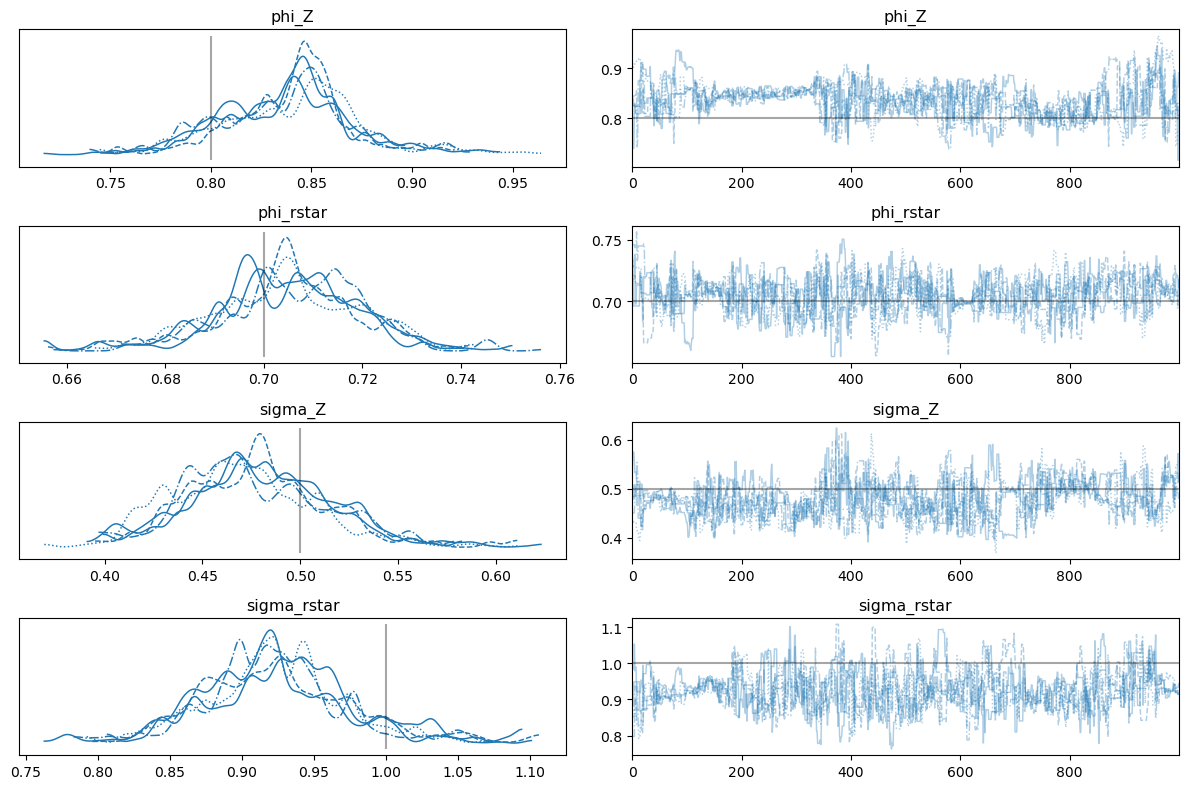

In [12]:
az.plot_trace(
    chains,
    lines = [
        ("phi_rstar", {}, 0.7),
        ("sigma_rstar", {}, 1.0),
        ("phi_Z", {}, 0.8),
        ("sigma_Z", {}, 0.5)
    ],
)

mpl.tight_layout()

## Parameter and Shock Estimation (WIP)

This is quite different from the shock estimation since we need to recompute
the steady state as well as the model Jacobian at every call of `likelihood`.
Not only is this a much slower process, but it requires slightly different
infromation than what is provided for the shocks.

In [13]:
def likelihood_2(kappa, phi_rstar, sigma_rstar, phi_Z, sigma_Z, data, ss, model, jacobian):
    # keep the household jacobian block constant
    J_ha = {"hh": model["hh"].jacobian(ss, inputs=["r", "Y", "T"], T=500)}

    # reparameterize the model and recompute the Jacobian
    ss_new = ss.copy()
    ss_new.update({"kappa": kappa})
    new_jacobian = model.solve_jacobian(
        ss_new, unknowns, targets, inputs, outputs, Js=J_ha, T=500
    )

    # construct shocks
    shocks = ShockDict({
        "rstar": AR(np.array([phi_rstar]), sigma_rstar),
        "Z": AR(np.array([phi_Z]), sigma_Z)
    })

    # construct impulse response functions
    impulses = shocks.generate_impulses(500)
    irfs = {i: new_jacobian @ {i: impulses[i]} for i in inputs}

    M = np.empty((500, len(outputs), len(inputs)))
    for no, o in enumerate(outputs):
        for ns, s in enumerate(inputs):
            M[:, no, ns] = irfs[s][o]

    # approximate the autocovariances
    Sigma = sje.all_covariances(M, 1)

    # compute the log posterior likelihood
    return sje.log_likelihood(data, Sigma)

In [14]:
dsge_logpdf_2 = DensityModel(
    data_simul, ss, hank_model, likelihood_2,
    unknowns, targets, inputs, T=500
)

In [ ]:
with mc.Model() as hank_2:
    # model params
    kappa = mc.Uniform("kappa", lower=0.01, upper=0.99)

    # rstar shock params
    phi_rstar = mc.Uniform("phi_rstar", lower=0.01, upper=0.99)
    sigma_rstar = mc.InverseGamma("sigma_rstar", alpha=3, beta=1)
    
    # Z shock params
    phi_Z = mc.Uniform("phi_Z", lower=0.01, upper=0.99)
    sigma_Z = mc.InverseGamma("sigma_Z", alpha=3, beta=1)

    likelihood = mc.Potential(
        "likelihood",
        dsge_logpdf_2(kappa, phi_rstar, sigma_rstar, phi_Z, sigma_Z)
    )

    # choose MH for sake of efficiency and slice sampling for convergence to posterior
    chains = mc.sample(
        1000,
        step = mc.DEMetropolis(),
        tune = 0,
        chains = 5
    )

The stack trace for this error is a little misleading since the number of draws
for kappa is only one in this case. I should run a debugger over this to look
under the hood.

```python
File ~/examples/hank.py:25, in nkpc(pi, w, Z, Y, r, mu, kappa)
     23 @simple
     24 def nkpc(pi, w, Z, Y, r, mu, kappa):
---> 25     nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
     26                - (1 + pi).apply(np.log)
     27     return nkpc_res

File ~/blocks/support/simple_displacement.py:240, in IgnoreVector.__mul__(self, other)
    239 if isinstance(other, Displace) or isinstance(other, AccumulatedDerivative):
--> 240     return other.__rmul__(numeric_primitive(self))
    241 else:

File ~/blocks/support/simple_displacement.py:615, in AccumulatedDerivative.__rmul__(self, other)
    614 else:
--> 615     raise NotImplementedError("This operation is not yet supported for non-scalar arguments")

```